# Imports and dataset loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.multioutput import MultiOutputRegressor
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

models        = []
strategyArray = []
gainArray     = []
lossArray     = []
ampNumber     = 2

originalDataSet = pd.read_csv('dataset.txt', sep = ',',header = None)
originalDataSet = originalDataSet.sample(frac = 1, random_state = 5)

binaryDataSet   = []

for line in originalDataSet.values:
    myList = [1 if i != 0 else 0 for i in line[:40]]
    myList.extend(line[40:])
    binaryDataSet.append(myList)

binaryDataSet = pd.DataFrame(binaryDataSet)
gainScaler    = MinMaxScaler(feature_range = (-1, 1))
lossScaler    = MinMaxScaler(feature_range = (-1, 1))

gainScalerAux = []
lossScalerAux = []

for i in range(0, ampNumber * 2, 2):
    gainScalerAux.extend(binaryDataSet.values[:, 40 + i])
    lossScalerAux.extend(binaryDataSet.values[:, 40 + i + 1])

gainScaler.fit(np.array(gainScalerAux).reshape(-1, 1))
lossScaler.fit(np.array(lossScalerAux).reshape(-1, 1))

def loadDataset(): 
    dataSet = binaryDataSet.values[:, :40]
    
    for i in range(0, ampNumber * 2, 2):
        gain    = np.array(binaryDataSet.values[:, 40 + i])
        gain    = gainScaler.transform(gain.reshape(-1, 1))
        dataSet = np.hstack((dataSet, gain))
        
        loss    = np.array(binaryDataSet.values[:, 40 + i + 1])
        loss    = lossScaler.transform(loss.reshape(-1, 1))
        dataSet = np.hstack((dataSet, loss))
            
    X, y = np.array(dataSet[:, :40]), np.array(dataSet[:, 40:])
    
    return X, y

def invertGainNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return round(gainScaler.inverse_transform(auxArray)[0][0])

def invertLossNorm(value):
    auxArray = np.array([value, 0, 0, 0, 0, 0]).reshape(-1, 1)
    return round(lossScaler.inverse_transform(auxArray)[0][0])
    
def getGainError(value1, value2):
    return (invertGainNorm(value1) - invertGainNorm(value2))**2

def getLossError(value1, value2):
    return (invertLossNorm(value1) - invertLossNorm(value2))**2

# Model setup

In [2]:
def initModels():
    models = []
    
    for i in range(ampNumber):
        models.append(MultiOutputRegressor(KNeighborsRegressor()))
    
    return models
        

# Cross validation function

In [3]:
def crossValidate(regressor, X, y, folds = 5):
    foldSize   = int(math.ceil(X.shape[0] / folds))
    gainErrors = []
    lossErrors = []
    
    for i in range(folds): 
        sliceBegin = i * foldSize
        sliceEnd   = (i + 1) * foldSize
        
        X_train = np.delete(X, np.s_[sliceBegin: sliceEnd], 0)
        y_train = np.delete(y, np.s_[sliceBegin: sliceEnd], 0)
        
        if isinstance(regressor, Sequential):
            regressor.fit(X_train, y_train, epochs = 500, verbose = 0)  
        else:
            regressor.fit(X_train, y_train)
            
        X_test = X[sliceBegin: sliceEnd]
        y_test = y[sliceBegin: sliceEnd]
        
        gainError = 0
        lossError = 0
        
        prediction = regressor.predict(X_test)
        
        for predicted, expected in zip(prediction, y_test):
            gainError += getGainError(predicted[0], expected[0]) 
            lossError += getLossError(predicted[1], expected[1])
                 
        gainErrors.append(gainError / foldSize)
        lossErrors.append(lossError / foldSize)
        
    return np.array(gainErrors), np.array(lossErrors)

In [4]:
def trainModel(models):   
    X, y                   = loadDataset()
    gainErrors, lossErrors = crossValidate(models[0], X, y[:, 0: 2])
    print(gainErrors, "=> %0.2f (+/- %0.2f)" % (math.sqrt(np.mean(gainErrors)), gainErrors.std() * 2))
    print(lossErrors, "=> %0.2f (+/- %0.2f)\n" % (math.sqrt(np.mean(lossErrors)), lossErrors.std() * 2))
    
    gainArray.append(gainErrors)
    lossArray.append(lossErrors)
    strategyArray.append("Amp 1")
    
    #prediction = models[0].predict(X)
    
    for i in range(1, ampNumber):
        #gainErrors, lossErrors = crossValidate(models[i], np.hstack((X, prediction)), y[:, i * 2: i * 2 + 2])
        gainErrors, lossErrors = crossValidate(models[i], X, y[:, i * 2: i * 2 + 2])
        print(gainErrors, "=> %0.2f (+/- %0.2f)" % (math.sqrt(np.mean(gainErrors)), gainErrors.std() * 2))
        print(lossErrors, "=> %0.2f (+/- %0.2f)\n" % (math.sqrt(np.mean(lossErrors)), lossErrors.std() * 2))

        gainArray.append(gainErrors)
        lossArray.append(lossErrors)
        strategyArray.append("Amp {}".format(i + 1))
        
        #prediction = models[i].predict(np.hstack((X, prediction)))
    
    return gainErrors, lossErrors

# Plotting functions

In [5]:
def plotDistribution(models):
    train_results = []
    test_results  = []
    
    features, result                 = loadDataset()
    X_train, X_test, y_train, y_test = train_test_split(features, result, test_size = 0.3, random_state = 0)
    
    models[0].fit(X_train, y_train[:, 0: 2])
    train_results.append(models[0].predict(X_train))
    test_results.append(models[0].predict(X_test))
    
    for i in range(1, ampNumber):
        models[i].fit(np.hstack((X_train, train_results[i - 1])), y_train[:, i * 2: i * 2 + 2])
        train_results.append(models[i].predict(np.hstack((X_train, train_results[i - 1]))))
        test_results.append(models[i].predict(np.hstack((X_test, test_results[i - 1]))))
    
    fig   = plt.figure(figsize = (15, 5))
    vGain = np.vectorize(invertGainNorm)
    vLoss = np.vectorize(invertLossNorm)
    
    for i in range(ampNumber):
        ax = fig.add_subplot(2, 2, i + 1)
        
        yGain    = vGain(y_test[:, i * 2])
        yLoss    = vLoss(y_test[:, i * 2 + 1])
        testGain = vGain(test_results[i][:, 0])
        testLoss = vLoss(test_results[i][:, 1])
        
        ax.scatter(yGain, yLoss)
        ax.scatter(testGain, testLoss, c = "m")
        ax.set_title("Amplifier {}".format(i + 1))
    
    fig.suptitle("Test Error", fontsize = 16)
    fig.text(0.5, 0.04, 'Gain', ha='center', va='center', fontsize = 14)
    fig.text(0.06, 0.5, 'Loss', ha='center', va='center', rotation='vertical', fontsize = 14)
    fig.legend(["expected", "predicted"])

    plt.show()
    return y_test, test_results

In [6]:
def plotGainError(yTest, predicted):
    fig, axis = plt.subplots(figsize = (10, 5))
    data      = []
    
    for i in range(ampNumber):
        gainError = []
        
        yTestAmp     = yTest[:, i * 2]
        predictedAmp = predicted[i][:, 0]
        
        for a, b in zip(predictedAmp, yTestAmp):
            gainError.append(math.sqrt(getGainError(a, b))) 

        data.append(gainError)
    
    axis.boxplot(data)
    axis.set_title("Test Gain Error", fontsize = 16)
    axis.set_xticklabels(np.repeat(strategyArray, 1))
    axis.set_ylabel("RMSE (dB)", fontsize = 14)

    plt.show()

In [7]:
def plotLossError(yTest, predicted):
    fig, axis = plt.subplots(figsize = (10, 5))
    data      = []
    
    for i in range(ampNumber):
        lossError = []
        
        yTestAmp     = yTest[:, i * 2 + 1]
        predictedAmp = predicted[i][:, 1]
        
        for a, b in zip(predictedAmp, yTestAmp):
            lossError.append(math.sqrt(getLossError(a, b)))
        
        data.append(lossError)
    
    axis.boxplot(data)
    axis.set_title("Test Loss Error", fontsize = 16)
    axis.set_xticklabels(np.repeat(strategyArray, 1))
    axis.set_ylabel("RMSE (dB)", fontsize = 14)

    plt.show()

In [8]:
def plotLinkTestError(yTest, predicted):
    fig, axis = plt.subplots(figsize = (10, 5))
    lossData  = [] 
    gainData  = [] 
    
    yTestGain     = yTest[:, 0]
    yTestLoss     = yTest[:, 1]
    predictedGain = np.array(predicted[0][:, 0]).flatten()
    predictedLoss = np.array(predicted[0][:, 1]).flatten()
    
    for i in range(1, ampNumber):
        yTestGain     = np.hstack((yTestGain, yTest[:, i * 2]))
        yTestLoss     = np.hstack((yTestLoss, yTest[:, i * 2 + 1]))
        predictedGain = np.hstack((predictedGain, np.array(predicted[i][:, 0]).flatten()))
        predictedLoss = np.hstack((predictedLoss, np.array(predicted[i][:, 1]).flatten()))
    
    for i in range(len(yTestGain)):
        lossData.append(getLossError(predictedLoss[i], yTestLoss[i]))
        gainData.append(getGainError(predictedGain[i], yTestGain[i]))
            
    print("Loss error mean: {}. Loss error median: {}".format(math.sqrt(np.mean(lossData)), np.median(lossData)))
    print("Gain error mean: {}. Gain error median: {}".format(math.sqrt(np.mean(gainData)), np.median(gainData)))
    
    print(len(lossData), len(gainData))
    
    axis.boxplot([lossData, gainData])
    axis.set_title("Link Test Error", fontsize = 16)
    axis.set_xticklabels(["Gain", "Loss"])
    axis.set_ylabel("RMSE (dB)", fontsize = 14)

    plt.show()

# Putting all together

In [9]:
gainArray = []
lossArray = []

In [10]:
models = initModels()
trainModel(models)

[7.23560209 6.21204188 7.02356021 7.86387435 7.0026178 ] => 2.66 (+/- 1.06)
[8.37958115 6.96596859 7.71989529 9.17539267 8.57591623] => 2.86 (+/- 1.52)

[5.39528796 6.79581152 6.4895288  6.95026178 5.87434555] => 2.51 (+/- 1.17)
[2.45549738 2.68062827 1.93455497 2.28795812 2.94764398] => 1.57 (+/- 0.69)



(array([5.39528796, 6.79581152, 6.4895288 , 6.95026178, 5.87434555]),
 array([2.45549738, 2.68062827, 1.93455497, 2.28795812, 2.94764398]))

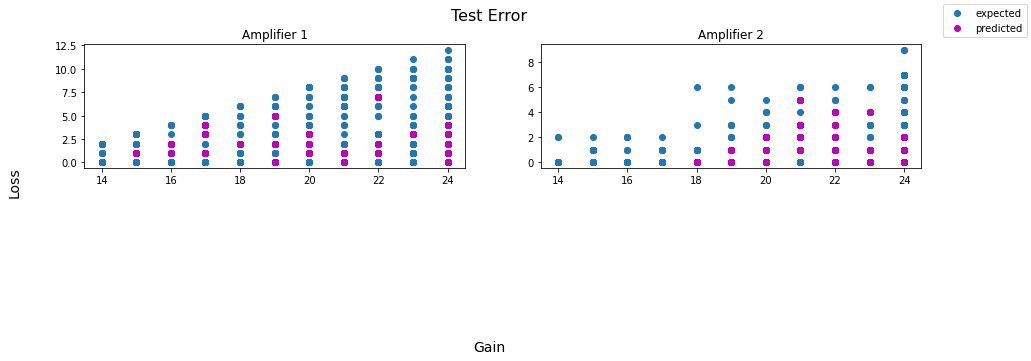

In [11]:
yTest, predicted = plotDistribution(models)

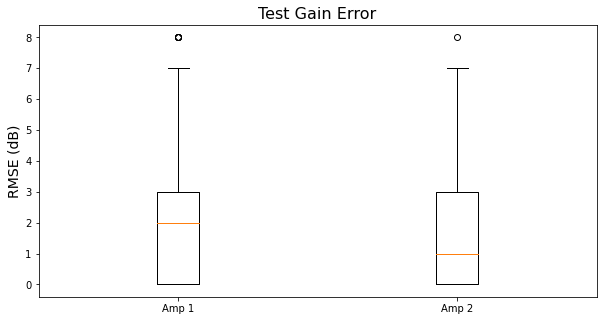

In [12]:
plotGainError(yTest, predicted)

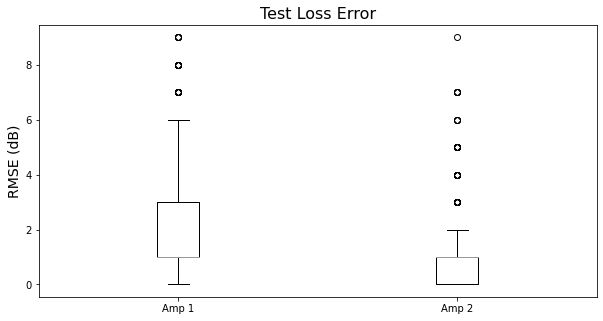

In [13]:
plotLossError(yTest, predicted)

Loss error mean: 2.309589992548975. Loss error median: 1.0
Gain error mean: 2.623560853730788. Gain error median: 1.0
1146 1146


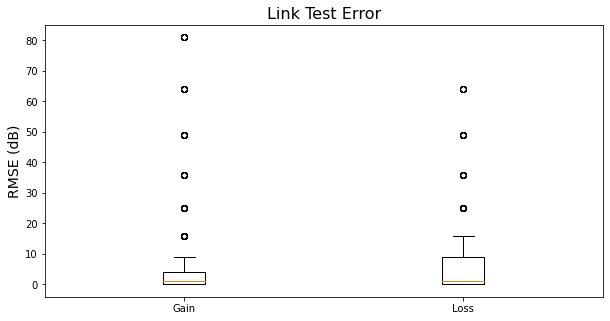

In [14]:
plotLinkTestError(yTest, predicted)